In [114]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from src.preprocessing import prepare_features

In [ ]:
df = pd.read_csv('../data/raw/retail_customers_COMPLETE_CATEGORICAL.csv')
df = prepare_features(df)

In [117]:
df.keys()

Index(['Recency', 'Frequency', 'MonetaryAvg', 'MonetaryStd', 'TotalQuantity',
       'AvgQuantityPerTransaction', 'CustomerTenureDays',
       'FirstPurchaseDaysAgo', 'PreferredDayOfWeek', 'PreferredMonth',
       'WeekendPurchaseRatio', 'AvgDaysBetweenPurchases', 'UniqueDescriptions',
       'UniqueCountries', 'NegativeQuantityCount', 'ZeroPriceCount',
       'ReturnRatio', 'AvgLinesPerInvoice', 'Age', 'SupportTicketsCount',
       'SatisfactionScore', 'RFMSegment', 'SpendingCategory',
       'PreferredTimeOfDay', 'ChurnRiskCategory', 'BasketSizeCategory',
       'Country', 'Churn', 'CustomerType_Nouveau', 'CustomerType_Occasionnel',
       'CustomerType_Régulier', 'FavoriteSeason_Hiver',
       'FavoriteSeason_Printemps', 'FavoriteSeason_Été',
       'Region_Amérique du Nord', 'Region_Amérique du Sud', 'Region_Asie',
       'Region_Autre', 'Region_Europe centrale', 'Region_Europe continentale',
       'Region_Europe de l'Est', 'Region_Europe du Nord',
       'Region_Europe du Sud', '

In [118]:
df["RFMSegment"].unique()

array([3, 4, 2, 1])

In [119]:
df.head()

,Recency,Frequency,MonetaryAvg,MonetaryStd,TotalQuantity,AvgQuantityPerTransaction,CustomerTenureDays,FirstPurchaseDaysAgo,PreferredDayOfWeek,PreferredMonth,...,Gender_M,Gender_Unknown,AccountStatus_Closed,AccountStatus_Pending,AccountStatus_Suspended,GeoIP,RegistrationMonth,RegistrationDay,RegistrationDayOfWeek,DaysSinceRegistration
0,302,35,16.950737,13.603662,1693,5.426282,71,374,3,12,...,False,True,False,False,False,0.268156,7,17,5,531
1,32,18,15.709694,11.684769,1355,6.913265,342,374,2,10,...,True,False,False,False,False,0.332990,10,4,0,452
2,3,18,28.634821,23.150132,5009,19.956175,370,374,4,11,...,False,True,False,False,False,0.339921,9,12,5,839
3,96,5,33.866071,42.953119,439,15.678571,278,374,0,9,...,False,True,False,False,False,0.303681,1,28,3,701
4,330,6,105.850000,215.986263,58,9.666667,43,374,2,12,...,True,False,False,False,False,0.415459,12,10,3,750


In [120]:
df["Age"].head()

0     NaN
1     NaN
2    46.0
3    32.0
4     NaN
Name: Age, dtype: float64

In [121]:
def plot_age_distribution(df):
    df["Age"].plot(kind='hist', bins=20, edgecolor='black')
    plt.axvline(df["Age"].mean(), color='red', linestyle='--', label=f'Mean: {df["Age"].mean():.2f}')
    plt.axvline(df["Age"].median(), color='green', linestyle='--', label=f'Median: {df["Age"].median():.2f}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Distribution of Age')
    plt.legend()
    plt.show()


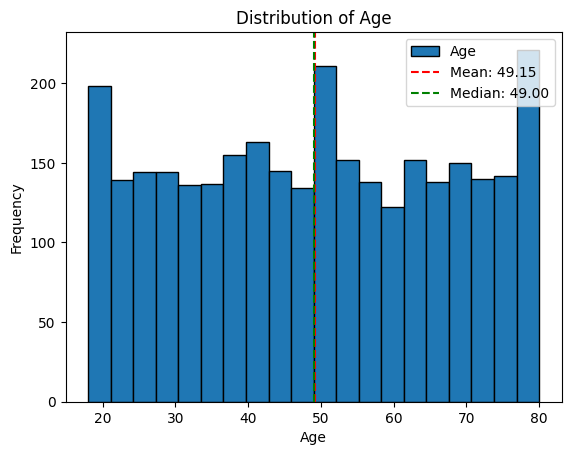

Mean Age: 49.15
Median Age: 49.00


In [122]:
plot_age_distribution(df)

print(f"Mean Age: {df['Age'].mean():.2f}")
print(f"Median Age: {df['Age'].median():.2f}")

In [123]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['AvgDaysBetweenPurchases'] = df['AvgDaysBetweenPurchases'].fillna(df['AvgDaysBetweenPurchases'].median())

print(f"Missing values after imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing values after imputation:
SatisfactionScore    349
dtype: int64


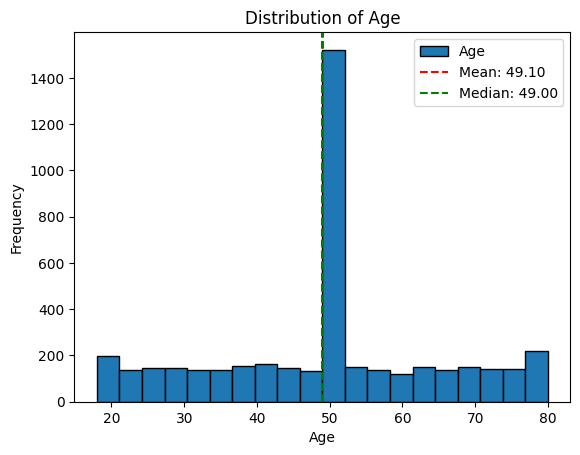

In [124]:
plot_age_distribution(df)

# They're equiprobably, 30% are missing so 30% are send to the median which skews the distribution heavily towards it.
# This cannot be right.

Given that that entirely skews the data. I'll look into the k means approach

In [ ]:
df = pd.read_csv('../data/raw/retail_customers_COMPLETE_CATEGORICAL.csv')
df = prepare_features(df)

In [ ]:


# Prepare feature matrix for VIF (exclude target)
X_vif = (
    # I don't want it to detect features that I already know are highly correlated with another pair.
    df.select_dtypes(include=[np.number, "bool"])
    .astype(float)
)

# VIF cannot handle NaN values
X_vif = X_vif.fillna(X_vif.median(numeric_only=True))

vif_threshold = 10.0
features_to_drop_vif = []

while True:
    # 1. ADD THE CONSTANT: This anchors the regression and fixes the "Age" bug
    X_vif_const = sm.add_constant(X_vif)
    
    # 2. Calculate VIFs
    vif_scores = pd.DataFrame(
        {
            "feature": X_vif_const.columns,
            "VIF": [
                variance_inflation_factor(X_vif_const.values, i)
                for i in range(X_vif_const.shape[1])
            ],
        }
    )
    
    # 3. Drop the 'const' row from the scores so we don't accidentally eliminate it
    vif_scores = vif_scores[vif_scores["feature"] != "const"].sort_values("VIF", ascending=False)

    # 4. Grab the worst offender
    max_feature = vif_scores.iloc[0]["feature"]
    max_vif = vif_scores.iloc[0]["VIF"]

    # 5. Break if the worst offender is under the threshold
    if np.isfinite(max_vif) and max_vif <= vif_threshold:
        break

    # 6. Otherwise, drop it and repeat
    features_to_drop_vif.append(max_feature)
    X_vif = X_vif.drop(columns=[max_feature])

# Final VIF table after iterative drops
X_vif_final_const = sm.add_constant(X_vif)
final_vif = pd.DataFrame(
    {
        "feature": X_vif_final_const.columns,
        "VIF": [
            variance_inflation_factor(X_vif_final_const.values, i) 
            for i in range(X_vif_final_const.shape[1])
        ],
    }
)
# Filter out the constant for the final display so it's clean
final_vif = final_vif[final_vif["feature"] != "const"].sort_values("VIF", ascending=False)

features_to_drop_vif = set(features_to_drop_vif)

# Display results
print(f"Dropped {len(features_to_drop_vif)} features due to VIF.")
features_to_drop_vif, final_vif.head(20)

Dropped 2 features due to VIF.


({'CustomerTenureDays', 'Recency'},
                      feature       VIF
 23         ChurnRiskCategory  7.076394
 26                     Churn  7.012837
 20                RFMSegment  6.271341
 1                  Frequency  4.760079
 11        UniqueDescriptions  4.310604
 6       FirstPurchaseDaysAgo  3.967888
 21          SpendingCategory  3.806851
 28  CustomerType_Occasionnel  2.978957
 25                   Country  2.815125
 27      CustomerType_Nouveau  2.608220
 31  FavoriteSeason_Printemps  2.603051
 16        AvgLinesPerInvoice  2.548180
 13     NegativeQuantityCount  2.252133
 30      FavoriteSeason_Hiver  2.241287
 56     DaysSinceRegistration  2.134935
 29     CustomerType_Régulier  2.128193
 8             PreferredMonth  2.016460
 9       WeekendPurchaseRatio  1.932175
 4              TotalQuantity  1.929260
 45   ProductDiversity_Modéré  1.929200)

Imputing missing values using KNNImputer...
Missing values after KNN imputation:
Age    0
dtype: int64


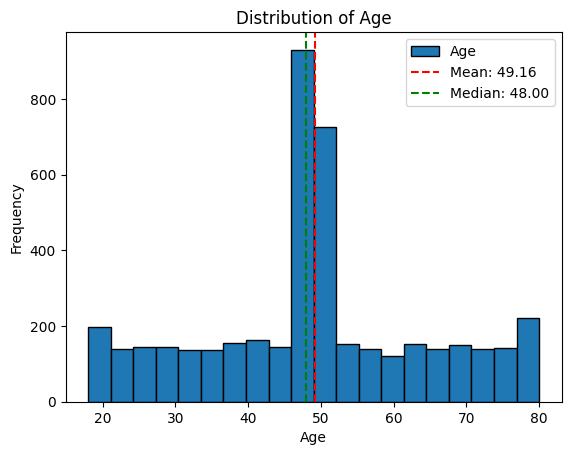

In [ ]:


# 2. Scale the data 
# Distance-based algorithms like KNN need scaled data so larger numbers don't dominate
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df), 
    columns=df.columns, 
    index=df.index
)

# 3. Apply KNNImputer
# n_neighbors=5 is a good default, but you can tune this
print("Imputing missing values using KNNImputer...")
imputer = KNNImputer(n_neighbors=1)
df_imputed_scaled = pd.DataFrame(
    imputer.fit_transform(df_scaled), 
    columns=df.columns, 
    index=df.index
)

# 4. Inverse transform to get back to original unscaled ages
df_imputed = pd.DataFrame(
    scaler.inverse_transform(df_imputed_scaled), 
    columns=df.columns, 
    index=df.index
)

# Update the original dataframe with the imputed Age column
df['Age'] = df_imputed['Age']

print("Missing values after KNN imputation:")
print(df[["Age"]].isna().sum())

plot_age_distribution(df)

In [133]:
# show columns that are most correlated with the Age column
age_corr = df.corr()["Age"].abs().sort_values(ascending=False)

age_corr

Age                            1.000000
FavoriteSeason_Hiver           0.061833
CustomerType_Régulier          0.041005
NegativeQuantityCount          0.040809
FirstPurchaseDaysAgo           0.039377
CustomerType_Occasionnel       0.036629
CustomerTenureDays             0.035970
Frequency                      0.035794
BasketSizeCategory             0.032624
UniqueDescriptions             0.031065
TotalQuantity                  0.028321
Gender_Unknown                 0.027982
ChurnRiskCategory              0.027048
FavoriteSeason_Été             0.026945
PreferredTimeOfDay             0.024699
ReturnRatio                    0.023606
RegistrationDayOfWeek          0.022930
RFMSegment                     0.021659
CustomerType_Nouveau           0.021599
Region_Asie                    0.021252
FavoriteSeason_Printemps       0.020188
Region_Europe de l'Est         0.019603
Churn                          0.019151
WeekendPreference_Semaine      0.017440
MonetaryStd                    0.016775
